<center>
    <img src="images/mtvs-ai-1.png" alt="" />
</center>

In [1]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour, OneSidedSelection, EditedNearestNeighbours, NeighbourhoodCleaningRule 
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE 
from imblearn.combine import SMOTEENN, SMOTETomek

import nltk
from nltk import Text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

## 데이터셋 정보

- v1: 스팸 라벨 데이터 ['ham', 'spam']
- v2: 메시지 내용
- Unnamed 2: 불필요한 데이터
- Unnamed 3: 불필요한 데이터
- Unnamed 4: 불필요한 데이터

In [2]:
# csv encoding type이 latin-1
df = pd.read_csv('csvs/spam.csv', encoding='latin-1')
# 데이터 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [3]:
# 불필요한 데이터 제거
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.columns = ['label', 'raw_text']
df.head()

,label,raw_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Spam Classification EDA 목차

## Ham, Spam 메시지 길이 시각화

## Imabalanced Dataset 

## Word Cloud

## Ham, Spam 상위 등장 빈도 30개 단어 시각화

In [4]:
# 메시지 길이 열 추가
df['raw_text_len'] = df['raw_text'].apply(lambda x: len(x))
df.head()

,label,raw_text,raw_text_len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


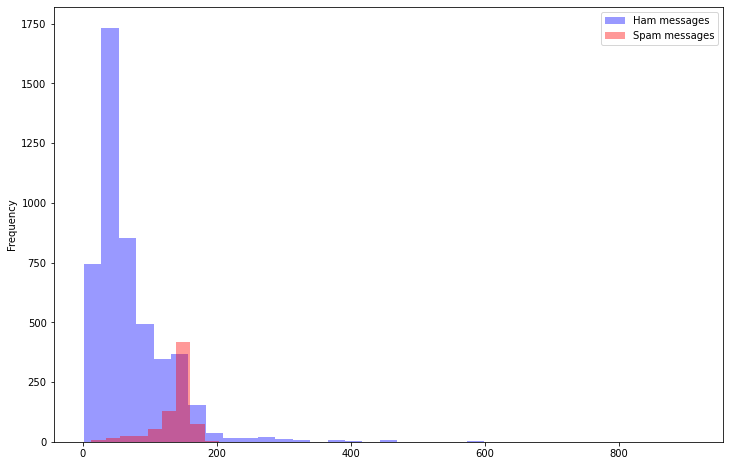

In [5]:
plt.figure(figsize=(12, 8)) 
df[df.label == 'ham']['raw_text_len'].plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.4) 
df[df.label == 'spam']['raw_text_len'].plot(kind='hist', color='red', label='Spam messages', alpha=0.4) 
plt.legend() 
# plt.xlabel("Message Length")

## <font color="white">스팸 데이터는 햄 데이터에 비해서 길이가 긴 경향성을 보인다.</font>

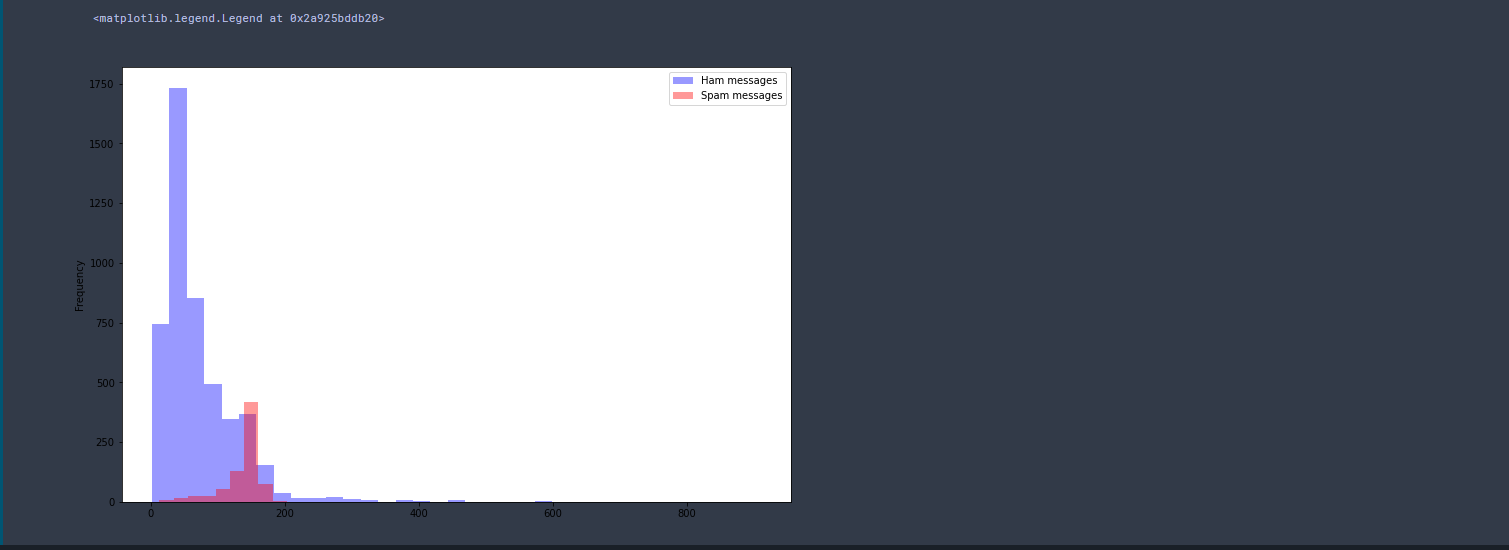

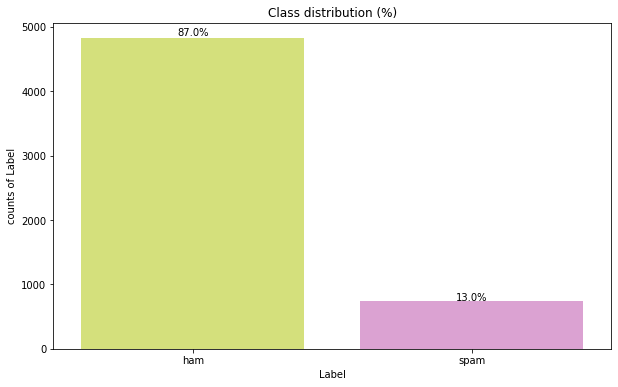

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
f = sns.countplot(x=df['label'], palette=["#E1F16B", "#E598D8"])
plt.xlabel('Label')
plt.ylabel('counts of Label')
plt.title('Class distribution (%)')
for p in f.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{round(height/df.shape[0], 2)*100}%',
                (x + width / 2, y + height * 1.01),
                ha='center')

plt.show()

## <font color="white">데이터의 불균형성</font>

### <font color="white">ham데이터와 spam데이터의 개수의 불균형으로 Imbalanced Datset의 형태를 갖추고 있다.</font>

<br />

### <font color="white">Imbalanced Datasets의 문제점</font>
- 갯수가 많은 레이블을 가진 데이터에 편향된 학습율을 보인다.
- 데이터 셋이 한 쪽으로 치우친 채로 모델 학습을 진행 했을 경우에 과적합 발생의 가능성이 높다.

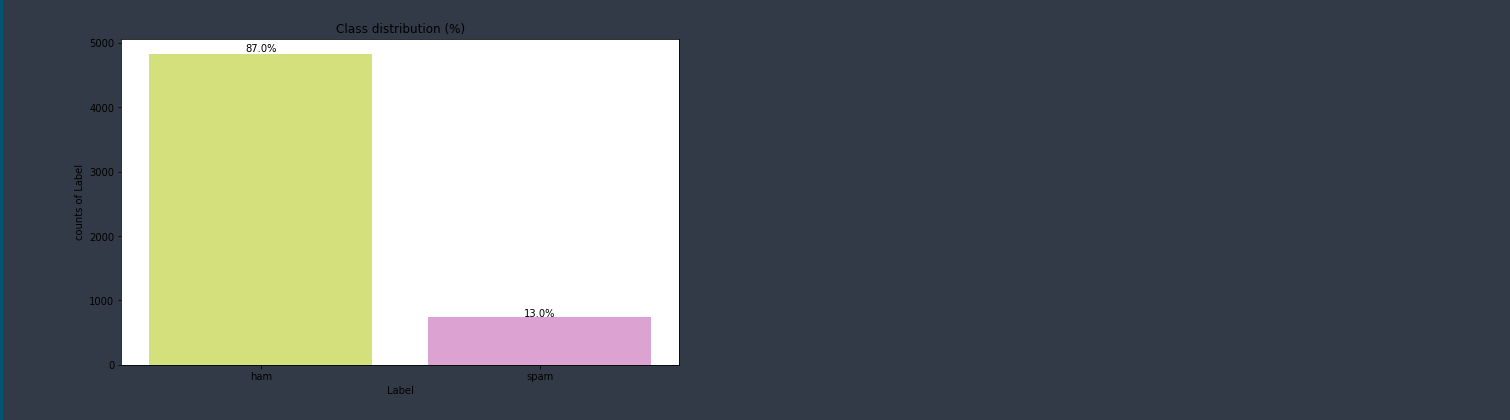

In [7]:
tmp = df.copy()

In [8]:
reg_token = RegexpTokenizer('[\w]+')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

result = []
ham_texts = []
spam_texts = []
for index, (text, label) in enumerate(zip(tmp['raw_text'], tmp['label'])):
    word_tokens = reg_token.tokenize(text)
    result.append([])

    for word in word_tokens:
        if word not in stop_words:
            temp = lemmatizer.lemmatize(word.lower())
            result[index].append(temp)

            if label == 'ham':
                ham_texts.append(temp)
            else:
                spam_texts.append(temp)

tmp['text'] = result
tmp['text'] = tmp['text'].str.join(' ')

In [9]:
tmp

,label,raw_text,raw_text_len,text
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i think go usf life around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,this 2nd time tried 2 contact u u å 750 pound ...
5568,ham,Will Ì_ b going to esplanade fr home?,37,will ì_ b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity mood so suggestion
5570,ham,The guy did some bitching but I acted like i'd...,125,the guy bitching i acted like interested buyin...


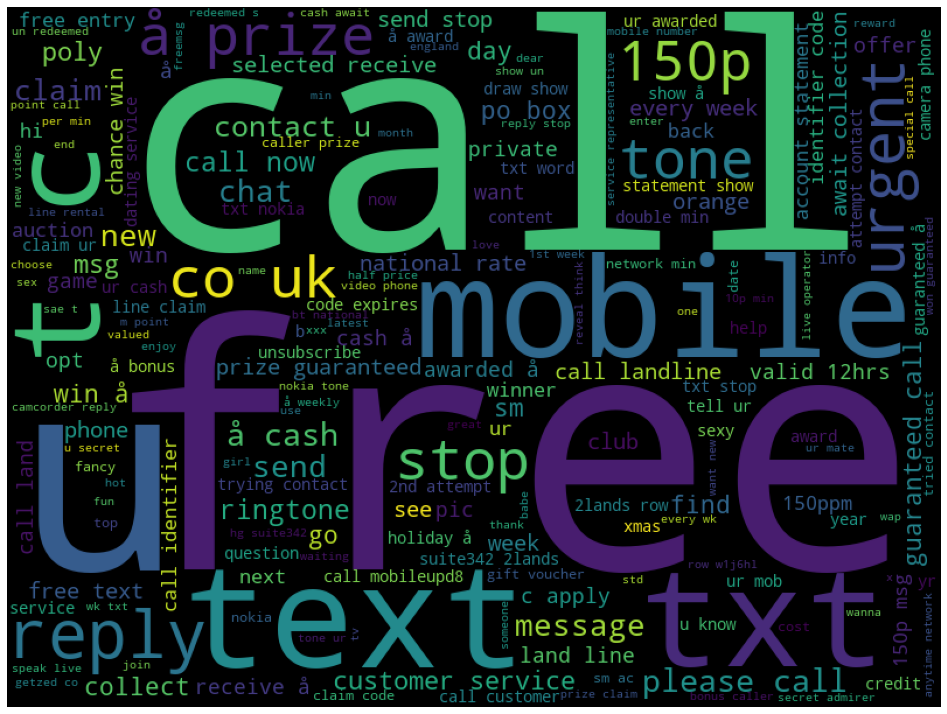

In [10]:
# spam sms 시각화
wc = WordCloud(
    width=800,
    height=600,
    background_color='black',
).generate(' '.join(spam_texts))

plt.figure(figsize=(18, 10))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

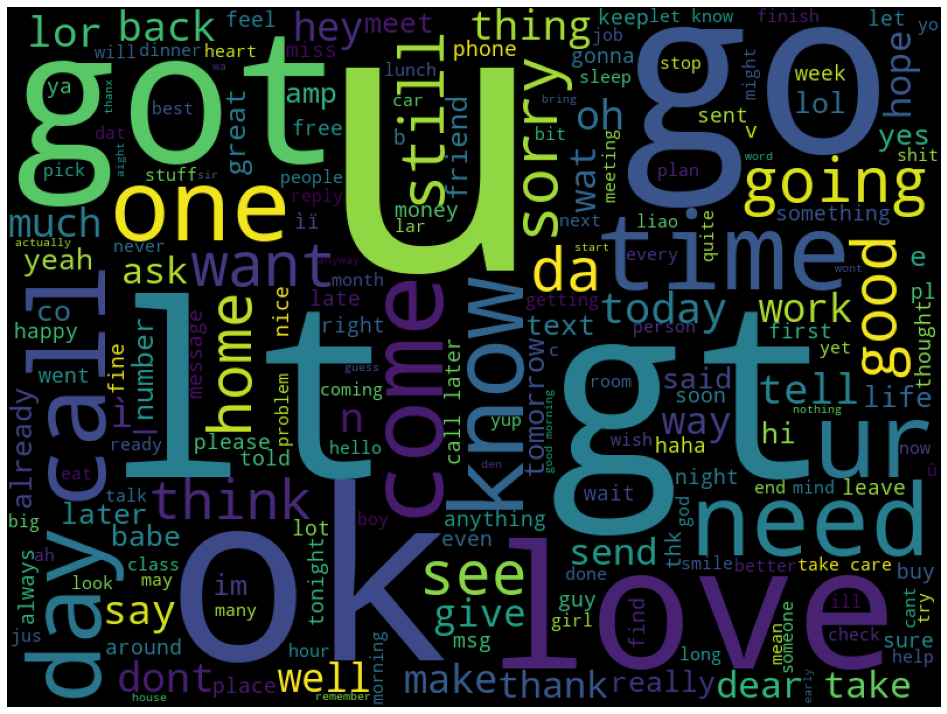

In [11]:
# ham sms 시각화
wc = WordCloud(
    width=800,
    height=600,
    background_color='black',
).generate(' '.join(ham_texts))

plt.figure(figsize=(18, 10))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

In [12]:
tmp[tmp['raw_text'].str.contains('&lt;#&gt;')][:5]

,label,raw_text,raw_text_len,text
44,ham,Great! I hope you like your man well endowed. ...,72,great i hope like man well endowed i lt gt inch
51,ham,"A gram usually runs like &lt;#&gt; , a half e...",124,a gram usually run like lt gt half eighth smar...
78,ham,Does not operate after &lt;#&gt; or what,42,doe operate lt gt
177,ham,Turns out my friends are staying for the whole...,146,turn friend staying whole show back til lt gt ...
199,ham,"Found it, ENC &lt;#&gt; , where you at?",40,found enc lt gt


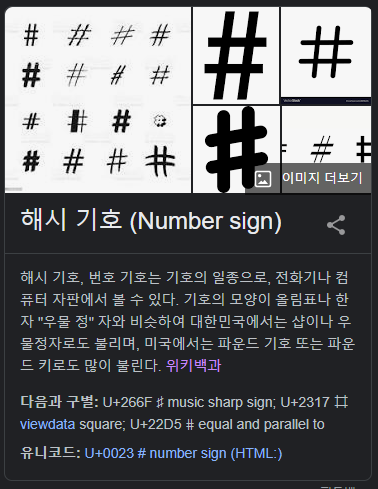

In [13]:
reg_token = RegexpTokenizer('[\w]+')
stop_words = stopwords.words('english')
stop_words.append('lt')
stop_words.append('gt')
lemmatizer = WordNetLemmatizer()

result = []
ham_texts = []
spam_texts = []
for index, (text, label) in enumerate(zip(df['raw_text'], df['label'])):
    word_tokens = reg_token.tokenize(text)
    result.append([])

    for word in word_tokens:
        if word not in stop_words:
            temp = lemmatizer.lemmatize(word.lower())
            result[index].append(temp)

            if label == 'ham':
                ham_texts.append(temp)
            else:
                spam_texts.append(temp)

df['text'] = result
df['text'] = df['text'].str.join(' ')

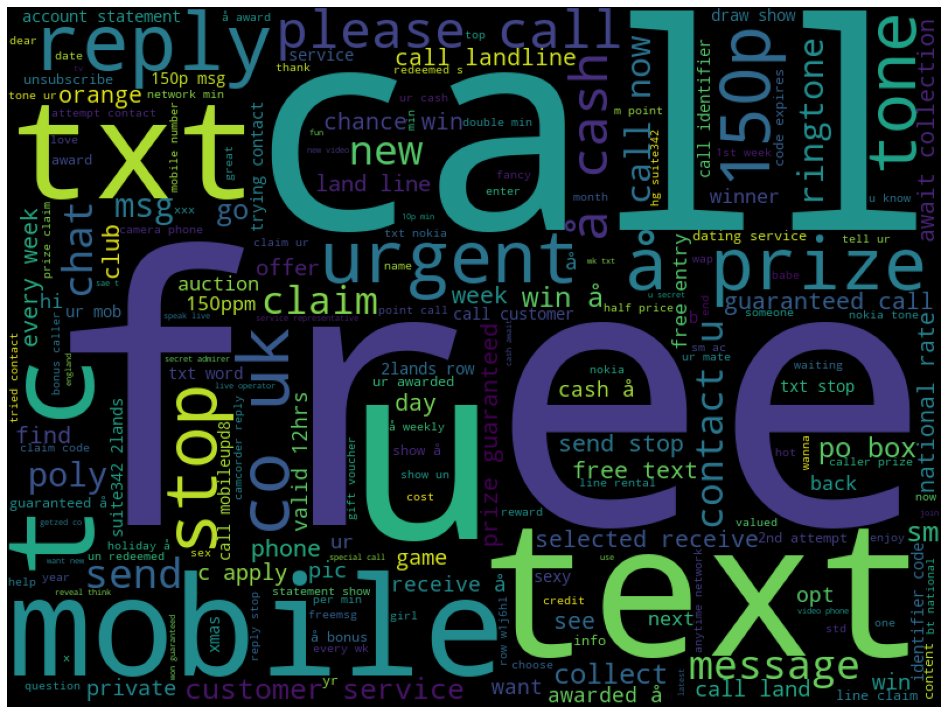

In [14]:
# spam sms 시각화
wc = WordCloud(
    width=800,
    height=600,
    background_color='black',
).generate(' '.join(spam_texts))

plt.figure(figsize=(18, 10))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

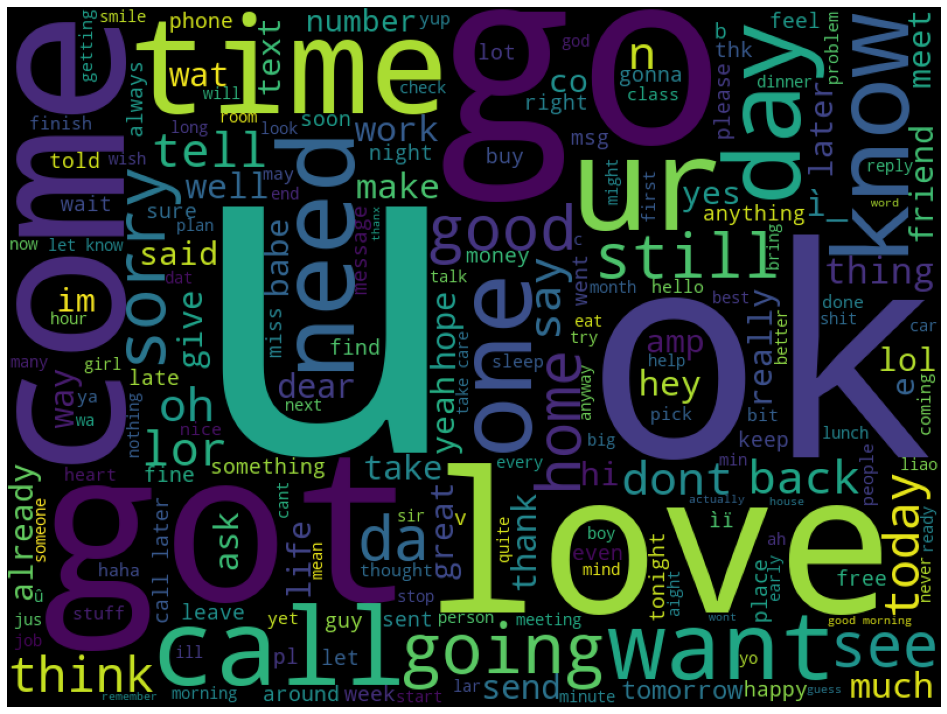

In [15]:
# ham sms 시각화
wc = WordCloud(
    width=800,
    height=600,
    background_color='black',
).generate(' '.join(ham_texts))

plt.figure(figsize=(18, 10))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

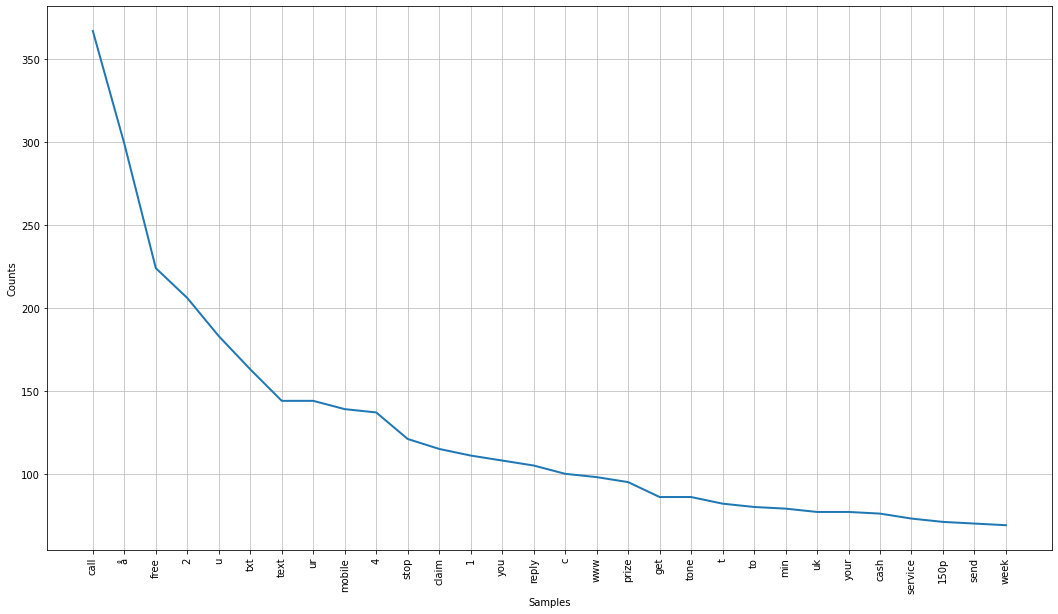

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [16]:
# 스팸 메시지에 등장한 상위 30개 단어
plt.figure(figsize=(18, 10))
Text(spam_texts).plot(30)

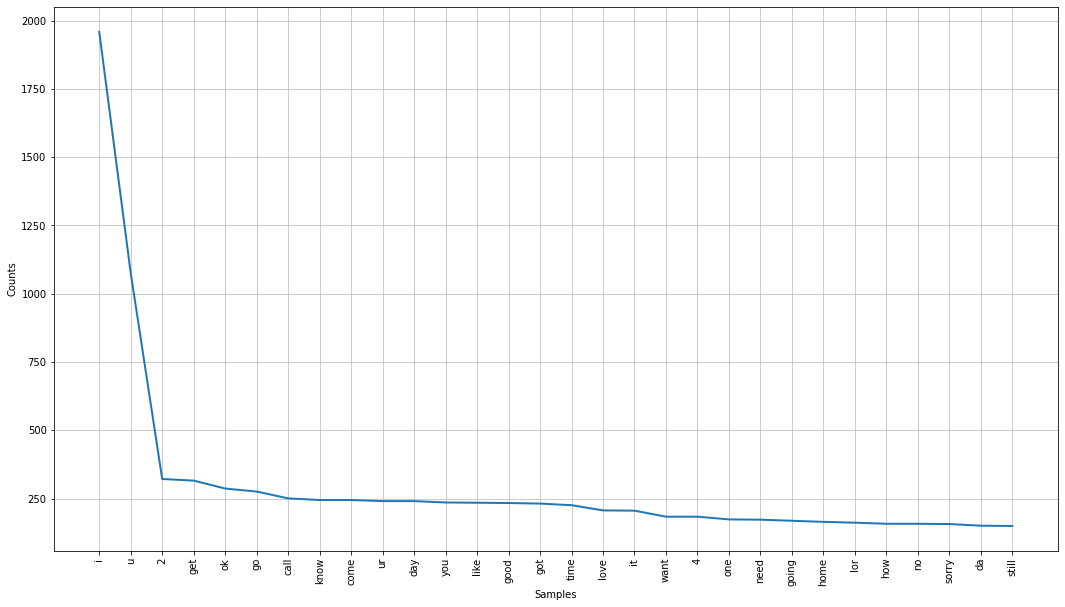

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [17]:
# 햄 메시지에 등장한 상위 30개 단어
plt.figure(figsize=(18, 10))
Text(ham_texts).plot(30)

In [18]:
df['spam'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['spam'],
                                                    test_size=0.2,
                                                    random_state=777)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [20]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train)
X_train_dtm = cv.transform(X_train)
X_test_dtm = cv.transform(X_test)

In [21]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)
X_test_tfidf = tfidf_transformer.transform(X_test_dtm)
X_train_tfidf.shape, y_train.shape

((4457, 6982), (4457,))

In [22]:
# Imbalanced Dataset 해결 위한 데이터 샘플링
sampling_method = ['RandomUnderSampling', 'TomekLinks', 'OneSidedSelection', 'EditedNearestNeighbours', 'NeighbourhoodCleaningRule', \
                   'RandomOverSampler', 'ADASYN', 'SMOTE', 'SMOTEENN', 'SMOTETomek', 'NoSampling']


def sampling(method, x_train, y_train):
    # Under Sampling
    if method == 'RandomUnderSampling':
        sampled_x, sampled_y = RandomUnderSampler(
            random_state=42).fit_resample(x_train, y_train)
    elif method == 'TomekLinks':
        sampled_x, sampled_y = TomekLinks().fit_resample(x_train, y_train)
    elif method == 'OneSidedSelection':
        sampled_x, sampled_y = OneSidedSelection(random_state=42).fit_resample(
            x_train, y_train)
    elif method == 'EditedNearestNeighbours':
        sampled_x, sampled_y = EditedNearestNeighbours(
            kind_sel='all', n_neighbors=5).fit_resample(x_train, y_train)
    elif method == 'NeighbourhoodCleaningRule':
        sampled_x, sampled_y = NeighbourhoodCleaningRule(
            kind_sel='all', n_neighbors=5).fit_resample(x_train, y_train)

    # Over Sampling
    elif method == 'RandomOverSampler':
        sampled_x, sampled_y = RandomOverSampler(random_state=42).fit_resample(
            x_train, y_train)
    elif method == 'ADASYN':
        sampled_x, sampled_y = ADASYN(random_state=42).fit_resample(
            x_train, y_train)
    elif method == 'SMOTE':
        sampled_x, sampled_y = SMOTE(random_state=42).fit_resample(
            x_train, y_train)

    # Combined Sampling:
    elif method == 'SMOTEENN':
        sampled_x, sampled_y = SMOTEENN(random_state=42).fit_resample(
            x_train, y_train)
    elif method == 'SMOTETomek':
        sampled_x, sampled_y = SMOTETomek(random_state=42).fit_resample(
            x_train, y_train)

    # Not Sampling
    else:
        sampled_x = x_train
        sampled_y = y_train

    return sampled_x, sampled_y

In [23]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)
bc = BaggingClassifier(n_estimators=50, random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=42)
xgb = XGBClassifier(n_estimators=50, random_state=42)

clfs = {
    'SVC': svc,  # SVC
    'KN': knc,  # KNeighborsClassifier
    'NB': mnb,  # MultinomialNB
    'DT': dtc,  # DecisionTreeClassifier
    'LR': lrc,  # LogisticRegression
    'RF': rfc,  # RandomForestClassifier
    'AdaBoost': abc,  # AdaBoostClassifier
    'BgC': bc,  # BaggingClassifier
    'ETC': etc,  # ExtraTreesClassifier
    'GBDT': gbdt,  # GradientBoostingClassifier
    'xgb': xgb  # XGBClassifier
}

In [24]:
def train_classifier(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test )

    # accuracy
    accuracy = accuracy_score(y_test, y_predict)
    # precision
    precision = precision_score(y_test, y_predict)

    # recall, f1 score
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)

    # AUC, ROC curve
    roc_score = roc_auc_score(y_test, y_predict)

    return y_predict, accuracy, precision, recall, f1, roc_score

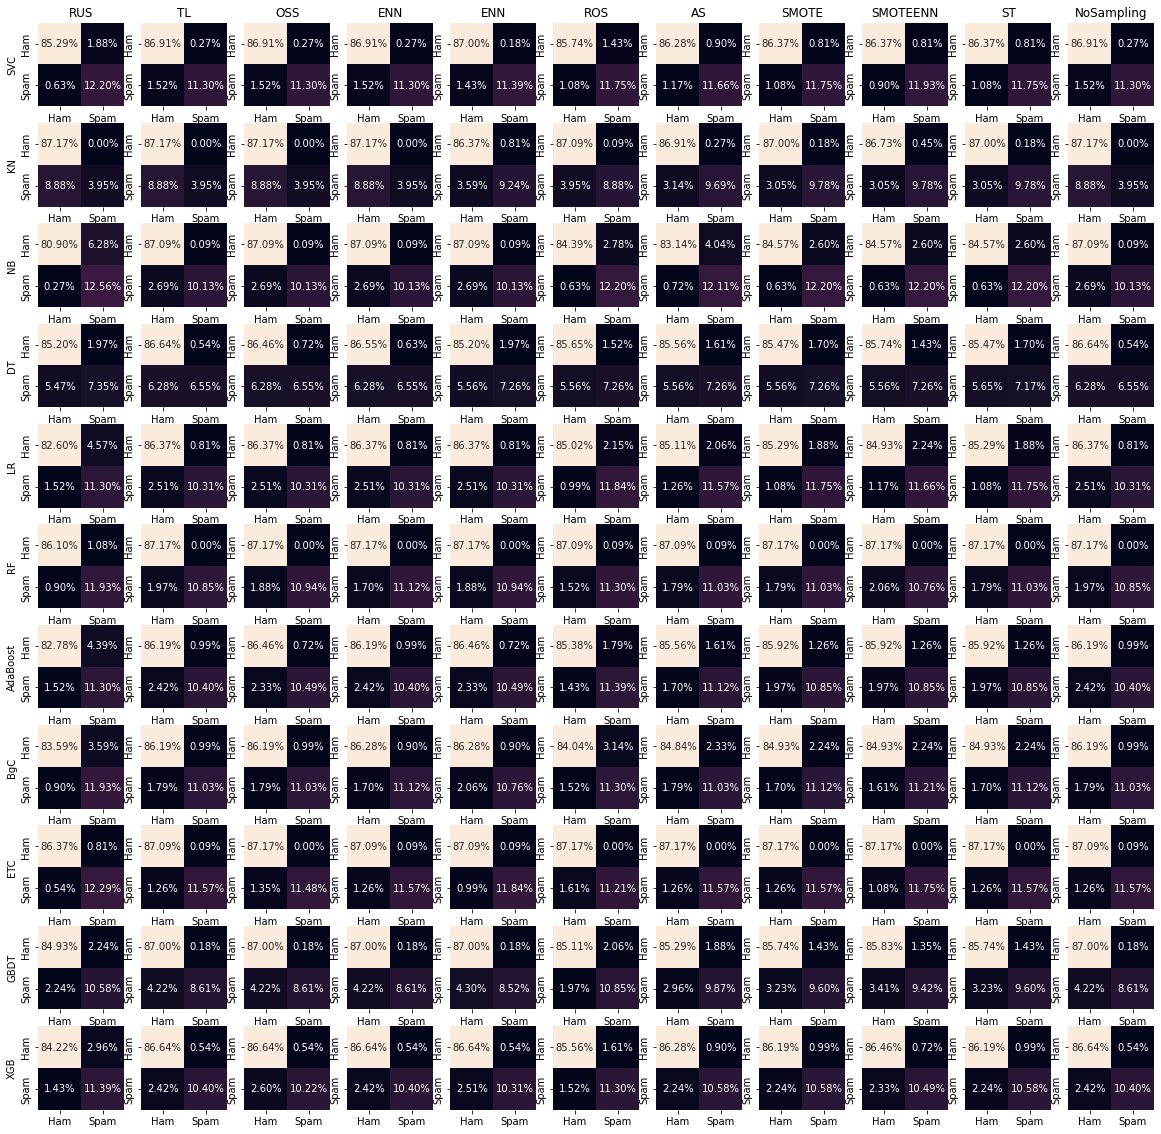

In [25]:
# Compare metrics of sampling, classification models 
# with confusion metrixes with percentage 
# and several different metrics

scores = {}
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
roc_score_list = []


fig, axes = plt.subplots(nrows=len(clfs),
                         ncols=len(sampling_method),
                         figsize=(20, 20)) 
Labels = ['Ham', "Spam"]
sampling_method_list = ['RUS', 'TL', 'OSS', 'ENN', 'ENN', \
                   'ROS', 'AS', 'SMOTE', 'SMOTEENN', 'ST', 'NoSampling']
classification_model_list = ['SVC', 'KN', 'NB', 'DT', 'LR', \
                             'RF', 'AdaBoost', 'BgC', 'ETC', 'GBDT', \
                             'XGB']

for i, (name, clf) in enumerate(clfs.items()):
    for j, method in enumerate(sampling_method):
        sampled_x, sampled_y = sampling(method, X_train_tfidf, y_train)
        
        y_predict, accuracy, precision, recall, f1, roc_score = train_classifier(
            clf, sampled_x, sampled_y, X_test_tfidf, y_test)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_predict)
        fig = sns.heatmap(cm / np.sum(cm),
                    annot=True,
                    fmt='.2%',
                    cbar=False,
                    xticklabels=Labels,
                    yticklabels=Labels,
                    ax=axes[i, j])
        # Show sampling method, model 
        if i == 0:
            fig.title.set_text(str(sampling_method_list[j]))
        if j == 0:
            fig.set_ylabel(str(classification_model_list[i]))
        
        # Save Metrics
        score = {}
        score[(name, method)] = {accuracy, precision, recall, f1, roc_score}
        scores.update(score)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        roc_score_list.append(roc_score)

    scores[name] = [accuracy, precision, recall, f1, roc_score]

In [26]:
param_xgb = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_child_weight': [1, 2, 3, 5, 6, 7, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70],
}

gscv_xgb = GridSearchCV(estimator=xgb,
                        param_grid=param_xgb,
                        scoring='accuracy',
                        cv=2)

gscv_xgb.fit(X_train_tfidf, y_train)
gscv_xgb.score(X_train_tfidf, y_train), gscv_xgb.score(X_test_tfidf, y_test)
gscv_xgb.best_score_

print('best parameters : ', gscv_xgb.best_params_)

best parameters :  {'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 50}


현실에서의 적용 방법
<br />
새롭게 사업을 시작하는 회사들에게 광고성 이메일이나 SMS를 전송할 때 스팸처리 되는 것을 방지하는 방법에 대해서 컨설팅 가능
<br />
아쉬웠던 점
<br />
kaggle의 데이터셋이 교육을 목적으로해서 정확도가 너무 높게 나오는 것이 아쉽다.
<br />
우리가 만든 학습 모델이 과연 방대한 현실의 스팸 데이터를 우리가 학습 시킨 모델의 정확도 만큼 맞출 수 있는지 확인하고, 만약에 맞추지 못한다면 어째서 맞추지 못했고 그 데이터들은 어떤 특징들을 가지고 있는지 분석하고 싶었는데 데이터를 구하기가 어려웠다.
<br />
데이터셋을 전처리하는게 어려웠는데, 처음으로 데이터셋을 전처리하다보니 아무래도 경험 부족으로 어떻게 데이터를 전처리해야 유의미한 결과를 도출해낼 수 있는지에 대해서 많은 시간과 시도가 필요했다. 예를들자면 위의 lt, gt
<br />
좋았던 점
<br />
이의진
<br />
팀 프로젝트를 하면서 서로 어떤 생각과 어떤 목적으로 과제를 수행할지 의견을 나눌 수 있었던 것이 좋았다.
<br />
신우진
<br />
요즘 각광받고 있는 자연어 처리를 시작하는 데 있어서 어떻게 작동하는지 그 원리를 알 수 있었던 것이 좋았다.
<br />
김현진
<br />
자연어 처리와 관련된 많은 경험들 예를 들면, 데이터 전처리, Inbalanced Dataset Sampling, 다양한 모델 사용, Parameter Tunning 등을 할 수 있었어서 좋았다.
<br />
박인영
<br />
같은 주제로 서로 다른 사람들과 다양한 생각을 나눌 수 있는 경험을 할 수 있어서 좋았다.

<center>
    <img src="images/결론.png" alt="" />
</center>

<center>
    <img src="images/감사합니다.png" alt="" />
</center>